In [1]:
import importlib
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import interpolate

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
dimension = 2**9
print(dimension)

# rho0_l = 0.09
# rho0_s = 0.003

rho0_l = 0.2
rho0_m = 0.02
rho0_s = 0.002
# rho0 = 0.2
# dx = 0.25
dx = 1/dimension

# obs_size = int(dimension/2)
# H = assimilate.random_H(dimension, obs_size)

H = np.eye(dimension)[::2]
obs_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

512


In [6]:
eig_val_l, eig_vec_l, P_l, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_l, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('long variance: ', eig_val_l.mean())
eig_val_l = eig_val_l / eig_val_l.mean()
sort_index = np.argsort(sort_index)
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]
P_l = eig_vec_l @ np.diag(eig_val_l) @ eig_vec_l.conj().T
P_l = P_l.real

eig_val_m, eig_vec_m, P_m, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_m, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('medium variance: ', eig_val_m.mean())
eig_val_m = eig_val_m / eig_val_m.mean()
sort_index = np.argsort(sort_index)
eig_val_m = eig_val_m[sort_index]
eig_vec_m = eig_vec_m[:, sort_index]
P_m = eig_vec_m @ np.diag(eig_val_m) @ eig_vec_m.conj().T
P_m = P_m.real

eig_val_s, eig_vec_s, P_s, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_s, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('short variance: ', eig_val_s.mean())
eig_val_s = eig_val_s / eig_val_s.mean()
sort_index = np.argsort(sort_index)
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]
P_s = eig_vec_s @ np.diag(eig_val_s) @ eig_vec_s.conj().T
P_s = P_s.real
#P_s = P_s/P_s.max()

al = 0.40
am = 0.40
eig_val = (1 - al - am) * eig_val_s + am * eig_val_m + al * eig_val_l

# al = 0.5
# eig_val = (1 - al) * eig_val_s + al * eig_val_l

eig_vec = eig_vec_l.copy()

eig_val = eig_val / eig_val.mean()

sort_index = np.argsort(eig_val)[::-1]
eig_val = eig_val[sort_index]
eig_vec = eig_vec[:, sort_index]

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

sort_index = np.argsort(eig_val_l)[::-1]
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]

sort_index = np.argsort(eig_val_m)[::-1]
eig_val_m = eig_val_m[sort_index]
eig_vec_m = eig_vec_m[:, sort_index]

sort_index = np.argsort(eig_val_s)[::-1]
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]

R_sig = 1
R = R_sig * np.eye(obs_size)

trans_mats_true = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)


trans_mats_long = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_l, eig_vec_p=eig_vec_l,
    R=R, return_Ts=True)

trans_mats_med = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_m, eig_vec_p=eig_vec_m,
    R=R, return_Ts=True)


trans_mats_short = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_s, eig_vec_p=eig_vec_s,
    R=R, return_Ts=True)


for key, val in trans_mats_true.items():
    exec(key + '=val')
for key, val in trans_mats_long.items():
    exec(key+'_l' + '=val')
for key, val in trans_mats_med.items():
    exec(key+'_m' + '=val')
for key, val in trans_mats_short.items():
    exec(key+'_s' + '=val')

long variance:  1.000007453306344
medium variance:  1.0
short variance:  0.9987043816800435


Log10(condition):  4.5910922261552605


Text(0.5, 0.98, 'Eigenvalues P_s')

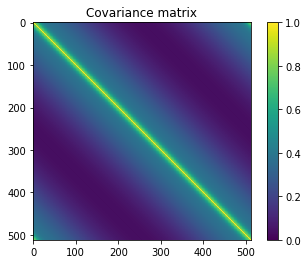

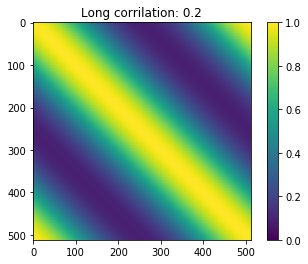

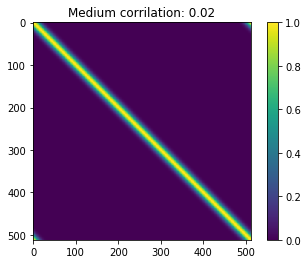

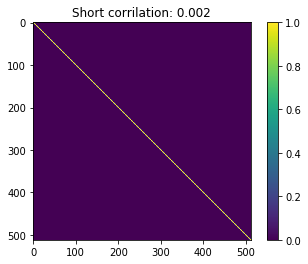

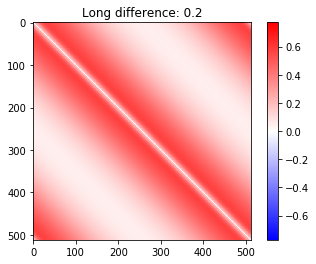

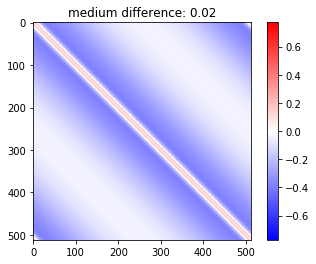

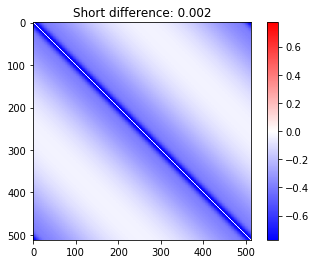

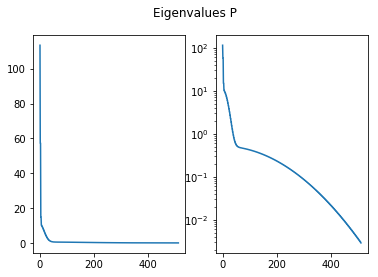

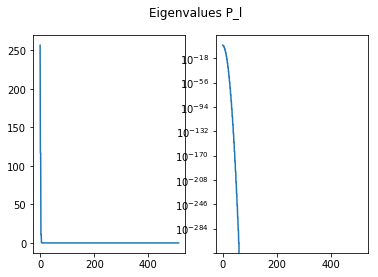

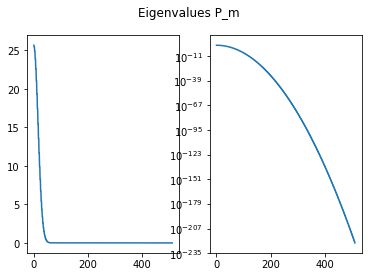

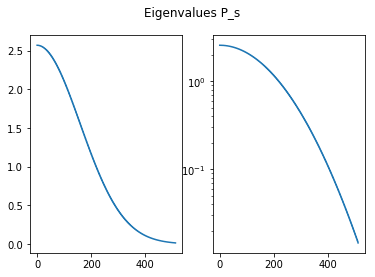

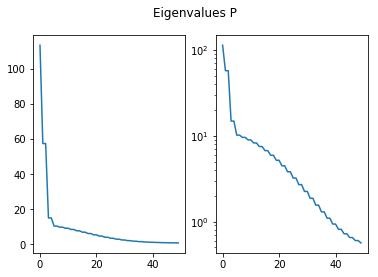

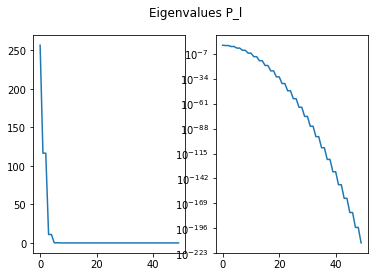

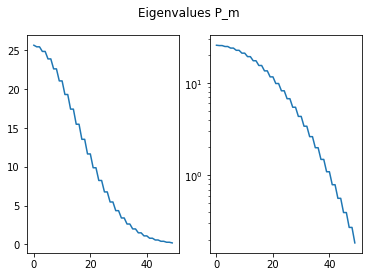

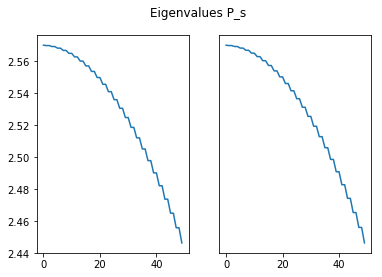

In [7]:
imshow(P, title='Covariance matrix', vmin=0, vmax=1)
imshow(P_l, title=f'Long corrilation: {rho0_l}', vmin=0, vmax=1)
imshow(P_m, title=f'Medium corrilation: {rho0_m}', vmin=0, vmax=1)
imshow(P_s, title=f'Short corrilation: {rho0_s}', vmin=0, vmax=1)

error_l = P_l - P
error_m = P_m - P
error_s = P_s - P

vmax = np.max([np.abs(error_l).max(),
               np.abs(error_s).max(),
               np.abs(error_m).max()])

imshow(error_l, title=f'Long difference: {rho0_l}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
imshow(error_m, title=f'medium difference: {rho0_m}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
imshow(error_s, title=f'Short difference: {rho0_s}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
print('Log10(condition): ',
      np.log10(np.linalg.cond(P)))

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val)
ax[1].semilogy(eig_val)
plt.suptitle('Eigenvalues P')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_l)
ax[1].semilogy(eig_val_l)
plt.suptitle('Eigenvalues P_l')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_m)
ax[1].semilogy(eig_val_m)
plt.suptitle('Eigenvalues P_m')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_s)
ax[1].semilogy(eig_val_s)
plt.suptitle('Eigenvalues P_s')

plot_sig_num = 50
fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val[:plot_sig_num])
ax[1].semilogy(eig_val[:plot_sig_num])
plt.suptitle('Eigenvalues P')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_l[:plot_sig_num])
ax[1].semilogy(eig_val_l[:plot_sig_num])
plt.suptitle('Eigenvalues P_l')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_m[:plot_sig_num])
ax[1].semilogy(eig_val_m[:plot_sig_num])
plt.suptitle('Eigenvalues P_m')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_s[:plot_sig_num])
ax[1].semilogy(eig_val_s[:plot_sig_num])
plt.suptitle('Eigenvalues P_s')

# R^{-1/2} H P^{1/2} = U S VT

In [8]:
trans_mats = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    print(key)
    exec(key + '=val')

P_sqrt
P_inv_sqrt
R_sqrt
R_inv_sqrt
U
S
VT
H
Tx
Tx_inv
Ty
Ty_inv


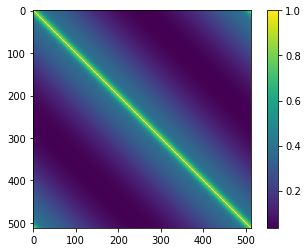

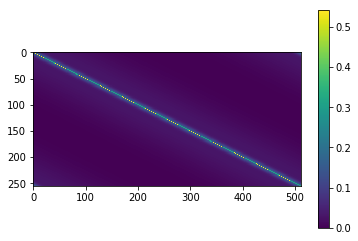

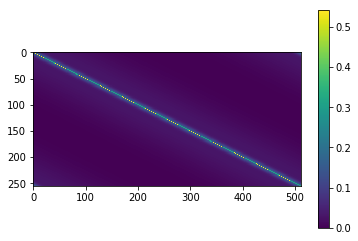

In [9]:
imshow(P_sqrt @ P_sqrt)
imshow(H @ P_sqrt)
imshow(U @ S @ VT)

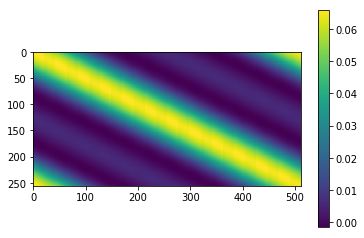

In [10]:
sig_num = 5
imshow(U[:, :sig_num] @ S[:sig_num, :sig_num] @ VT[:sig_num])

In [11]:
ens_size = 30
X = assimilate.generate_ensemble(ens_size=ens_size,
                                       mu=np.zeros(dimension),
                                       eig_val=eig_val,
                                       eig_vec=eig_vec
                                       )
P_sample = np.cov(X)

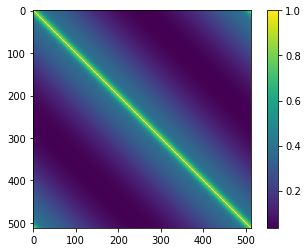

In [12]:
imshow(P)

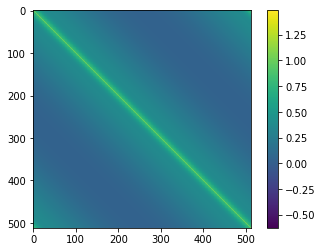

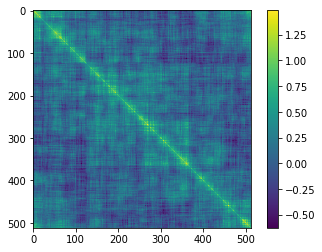

In [13]:
vmax = np.max([P_sample.max(), P.max()])
vmin = np.min([P_sample.min(), P.min()])

imshow(P, vmax=vmax, vmin=vmin)
imshow(P_sample, vmax=vmax, vmin=vmin)

In [14]:
def loc_with_trans(P_sample, P_sqrt, P_inv_sqrt, VT):
    P_til_loc = np.diag(np.diag(
        VT @ P_inv_sqrt @ P_sample @ P_inv_sqrt @ VT.T))
    P_sample_loc = P_sqrt @ VT.T @ P_til_loc @ VT @ P_sqrt
    return P_sample_loc

In [15]:
def test_trans_matrices(P, P_sample, P_sqrt, P_inv_sqrt, VT, title):
    P_sample_loc = loc_with_trans(P_sample=P_sample,
                                  P_sqrt=P_sqrt,
                                  P_inv_sqrt=P_inv_sqrt,
                                  VT=VT)
    vmax = np.max([P_sample.max(), P_sample_loc.max(), P.max()])
    vmin = np.min([P_sample.min(), P_sample_loc.min(), P.min()])

    imshow(P, vmax=vmax, vmin=vmin, title='truth')
    imshow(P_sample, vmax=vmax, vmin=vmin, title='sample')
    imshow(P_sample_loc, vmax=vmax, vmin=vmin, title=title)
    
    error_sample = P - P_sample
    error_loc = P - P_sample_loc
    L2_sample = np.round(np.linalg.norm(error_sample, ord=2), decimals=1)
    L2_loc = np.round(np.linalg.norm(error_loc, ord=2), decimals=1)
    vmax = np.max([np.abs(error_sample).max(),
                   np.abs(error_loc).max()])
    imshow(error_sample, vmax=vmax, vmin=-vmax,
           title='sample error' + f'; L2: {L2_sample}', cmap='bwr')
    imshow(error_loc, vmax=vmax, vmin=-vmax,
           title=title +' error' + f'; L2: {L2_loc}', cmap='bwr')
    return P_sample_loc

In [16]:
P_sample_loc = loc_with_trans(P_sample=P_sample,
                              P_sqrt=P_sqrt,
                              P_inv_sqrt=P_inv_sqrt,
                              VT=VT)

array([[0.90150046, 0.82514999, 0.72551508, ..., 0.69059285, 0.72726094,
        0.82602171],
       [0.82514999, 0.90039271, 0.82318217, ..., 0.67251197, 0.69074685,
        0.72554806],
       [0.72551508, 0.82318217, 0.89823129, ..., 0.65491668, 0.67324537,
        0.68987513],
       ...,
       [0.69059285, 0.67251197, 0.65491668, ..., 0.90899364, 0.82829548,
        0.72621098],
       [0.72726094, 0.69074685, 0.67324537, ..., 0.82829548, 0.90185225,
        0.82586771],
       [0.82602171, 0.72554806, 0.68987513, ..., 0.72621098, 0.82586771,
        0.90584639]])

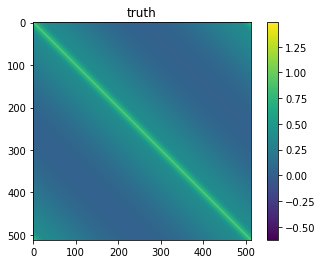

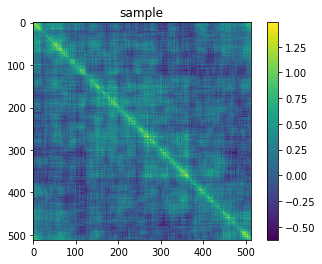

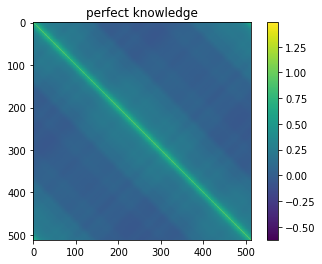

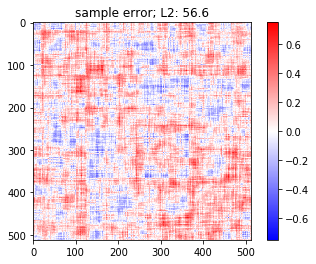

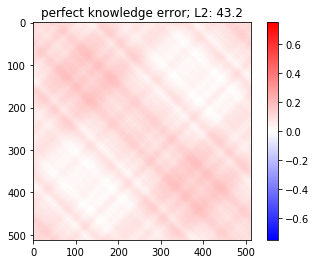

In [17]:
test_trans_matrices(P=P,
                    P_sample=P_sample,
                    P_sqrt=P_sqrt,
                    P_inv_sqrt=P_inv_sqrt,
                    VT=VT,
                    title='perfect knowledge')

array([[0.3927238 , 0.39264388, 0.39260269, ..., 0.39240176, 0.39260269,
        0.39264388],
       [0.39264388, 0.39262626, 0.39264739, ..., 0.39213524, 0.39239825,
        0.3925017 ],
       [0.39260269, 0.39264739, 0.39273083, ..., 0.39190738, 0.3922325 ,
        0.39239825],
       ...,
       [0.39240176, 0.39213524, 0.39190738, ..., 0.39264019, 0.39265437,
        0.3925087 ],
       [0.39260269, 0.39239825, 0.3922325 , ..., 0.39265437, 0.39273083,
        0.39264739],
       [0.39264388, 0.3925017 , 0.39239825, ..., 0.3925087 , 0.39264739,
        0.39262626]])

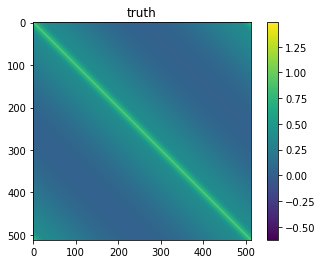

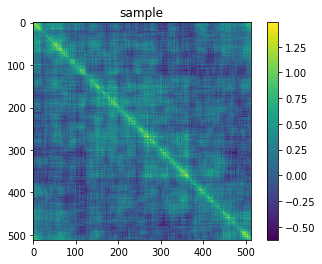

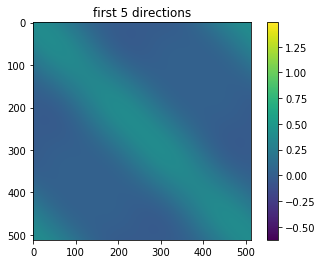

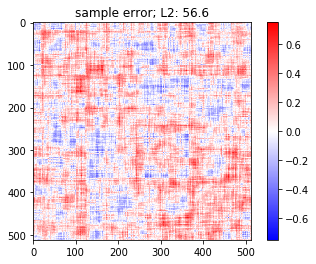

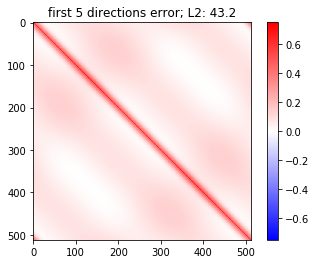

In [18]:
sig_num = 5
test_trans_matrices(P=P,
                    P_sample=P_sample,
                    P_sqrt=P_sqrt,
                    P_inv_sqrt=P_inv_sqrt,
                    VT=VT[:sig_num],
                    title=f'first {sig_num} directions')

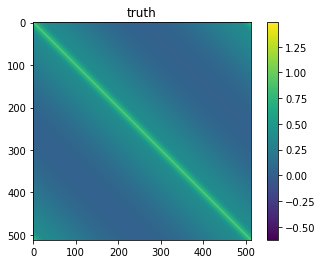

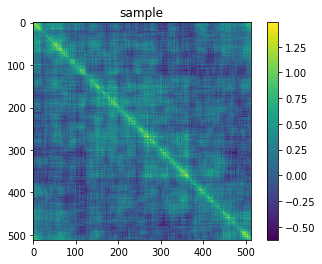

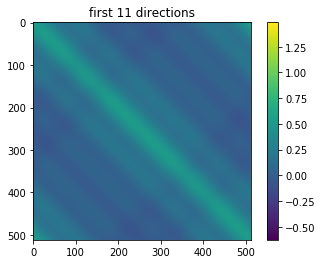

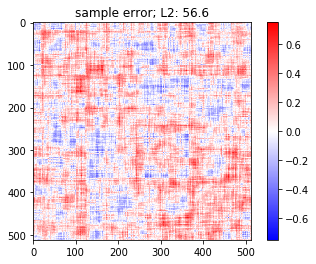

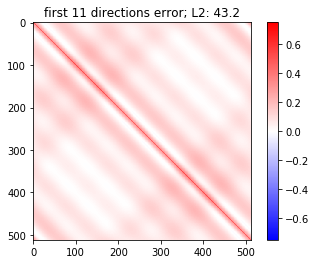

In [19]:
sig_num = 11
P_sample_loc = test_trans_matrices(P=P,
                    P_sample=P_sample,
                    P_sqrt=P_sqrt,
                    P_inv_sqrt=P_inv_sqrt,
                    VT=VT[:sig_num],
                    title=f'first {sig_num} directions')

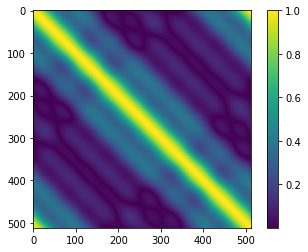

In [20]:
n = 1
P_n = (np.abs(P_sample_loc)**n)
loc = np.diag(np.diag(1/np.sqrt(P_n))) @ P_n @ np.diag(np.diag(1/np.sqrt(P_n)))
imshow(loc)

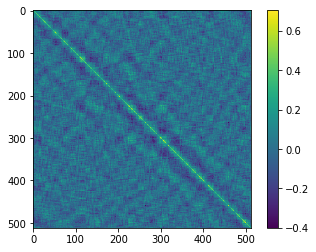

In [21]:
proj = np.eye(dimension) - VT[:sig_num].T @ VT[:sig_num]
imshow(proj @ P_sample @ proj)

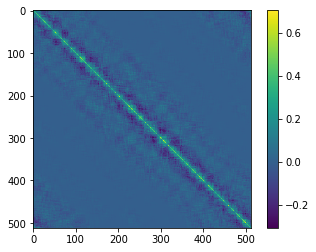

In [22]:
localized_orthogonal = loc * (proj @ P_sample @ proj)
imshow(localized_orthogonal)

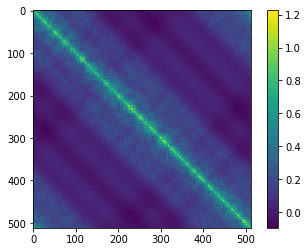

In [23]:
imshow(P_sample_loc + localized_orthogonal)

1


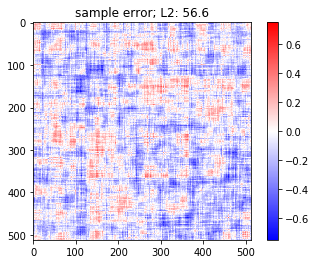

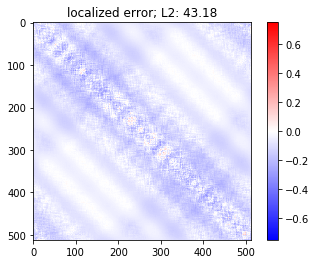

In [24]:
print(n)
error_sample = (P_sample - P)
error_localized = (P_sample_loc + localized_orthogonal) - P
L2_sample = np.round(np.linalg.norm(error_sample, ord=2), decimals=2)
L2_localized = np.round(np.linalg.norm(error_localized, ord=2), decimals=2)
vmax = np.max([np.abs(error_sample).max(), np.abs(error_localized).max()])
imshow(error_sample, vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample error; L2: {L2_sample}')
imshow(error_localized, vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'localized error; L2: {L2_localized}')

In [60]:
ens_size = 500
X_large = assimilate.generate_ensemble(ens_size=ens_size,
                                       mu=np.zeros(dimension),
                                       eig_val=eig_val,
                                       eig_vec=eig_vec
                                       )
P_sample_large = np.cov(X_large)

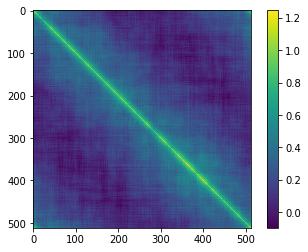

In [61]:
imshow(P_sample_large)

In [62]:
subnum = 16
X_subgrid = X_large.reshape(dimension // subnum, subnum, ens_size)
X_subgrid = X_subgrid.mean(axis=1)
P_sample_subgrid = np.cov(X_subgrid)

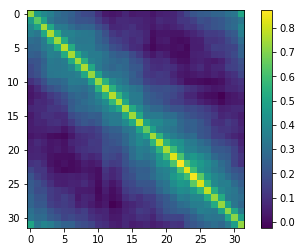

In [63]:
imshow(P_sample_subgrid)

In [90]:
D_inv_sqrt = np.diag(1/np.sqrt(np.diag((P_sample_subgrid))))
rho_sample_subgrid = D_inv_sqrt @ P_sample_subgrid @ D_inv_sqrt

In [91]:
H_subgrid = np.eye(P_sample_subgrid.shape[0])
R_subgrid = R_sig * np.eye(P_sample_subgrid.shape[0])
trans_mats = assimilate.transformation_matrices(
    H_subgrid, P=rho_sample_subgrid,
    R=R_subgrid, return_Ts=True)

for key, val in trans_mats.items():
    key = key + '_subgrid'
    print(key)
    exec(key + '=val')

P_sqrt_subgrid
P_inv_sqrt_subgrid
R_sqrt_subgrid
R_inv_sqrt_subgrid
U_subgrid
S_subgrid
VT_subgrid
H_subgrid
Tx_subgrid
Tx_inv_subgrid
Ty_subgrid
Ty_inv_subgrid


In [92]:
x_interp = np.arange(dimension)
# x_data = np.concatenate(
#     [x_interp[::subnum], [x_interp[-1] + 1]]) + 3.5
x_data = x_interp.reshape(int(dimension/subnum), subnum).mean(axis=1)
x_data = np.concatenate([[x_data[0] - subnum],
                         x_data,
                         [x_data[-1] + subnum]])
# x_data = np.concatenate(
#     [x_interp[::subnum], [x_interp[-1] + 1]]) + 3.5

In [93]:
VT_data = np.concatenate([VT_subgrid[:, -1][:, None],
                          VT_subgrid,
                          VT_subgrid[:, 0][:, None]],
                         axis=1)

In [94]:
interp_kind = 'cubic'
VT_fun = interpolate.interp1d(x_data, VT_data, kind=interp_kind, axis=1)

In [95]:
VT_subgrid_interp = VT_fun(x_interp)/np.sqrt(subnum)

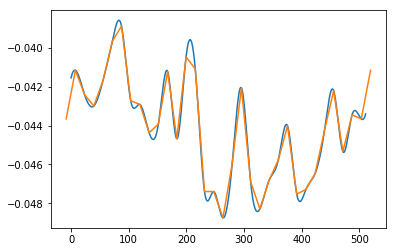

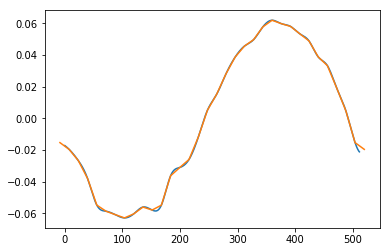

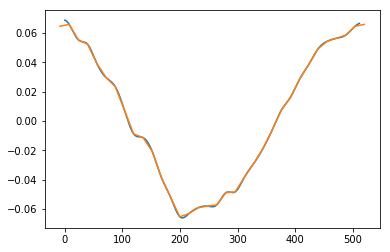

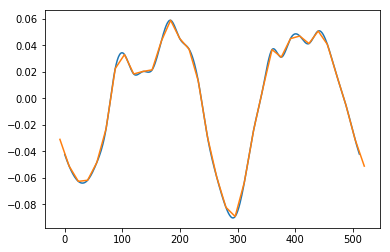

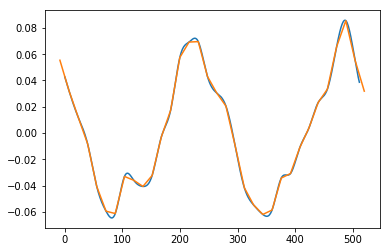

In [96]:
for ii in range(5):
    plt.figure()
    plt.plot(VT_subgrid_interp[ii])
    plt.plot(x_data, VT_data[ii]/np.sqrt(subnum))

In [97]:
U_data = np.concatenate([U_subgrid[-1, :][None, :],
                         U_subgrid,
                         U_subgrid[0, :][None, :]],
                        axis=0)

In [98]:
U_fun = interpolate.interp1d(x_data, U_data, kind=interp_kind, axis=0)

In [99]:
subnum

16

In [100]:
U_subgrid_interp = U_fun(x_interp)/np.sqrt(subnum)

In [101]:
%matplotlib inline

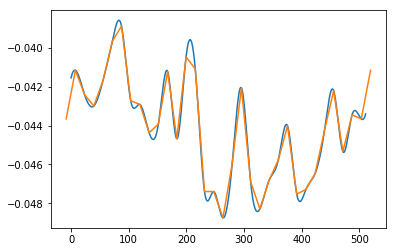

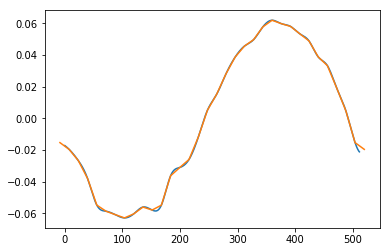

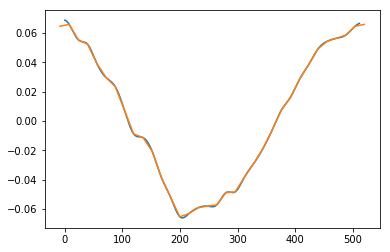

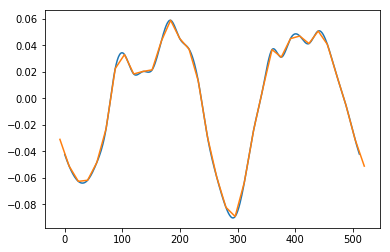

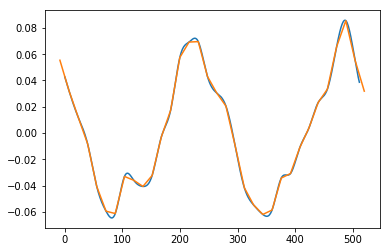

In [102]:
for ii in range(5):
    plt.figure()
    plt.plot(U_subgrid_interp[:, ii])
    plt.plot(x_data, U_data[:, ii]/np.sqrt(subnum))

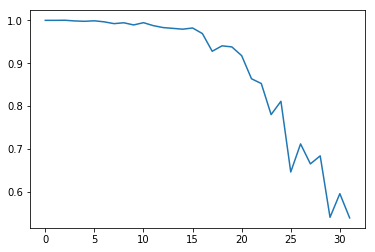

In [103]:
plt.plot(np.diag(U_subgrid_interp.T @ U_subgrid_interp))

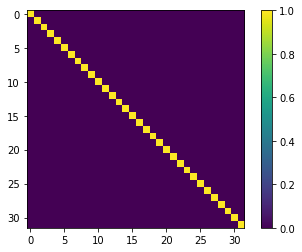

In [104]:
imshow(U_subgrid.T @ U_subgrid)

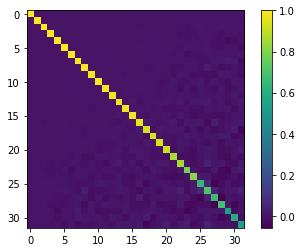

In [105]:
imshow(U_subgrid_interp.T @ U_subgrid_interp)

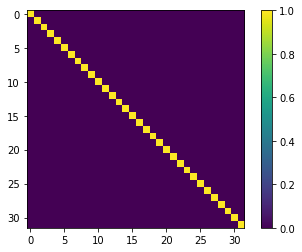

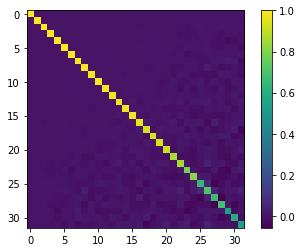

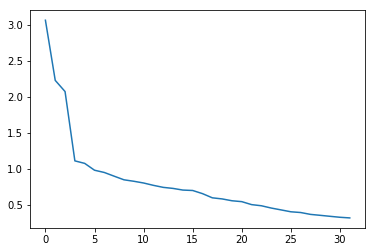

In [106]:
imshow(VT_subgrid @ VT_subgrid.T)
imshow(VT_subgrid_interp @ VT_subgrid_interp.T)
plt.figure()
plt.plot(np.diag(S_subgrid))

In [107]:
S_subgrid_interp = S_subgrid * np.sqrt(subnum)

In [108]:
subgrid_sig_num = 17

In [109]:
P_sample_interp_sqrt = (
    U_subgrid_interp[:, :subgrid_sig_num]
    @ S_subgrid_interp[:subgrid_sig_num, :subgrid_sig_num]
    @ VT_subgrid_interp[:subgrid_sig_num, :])
P_sample_interp = P_sample_interp_sqrt @ P_sample_interp_sqrt

In [111]:
%matplotlib notebook

In [112]:
%matplotlib inline

In [113]:
P_sample_interp.trace()/dimension

0.8964071917746079

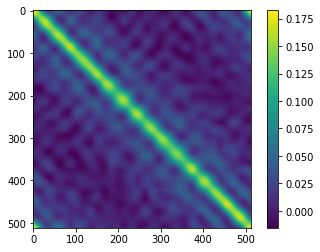

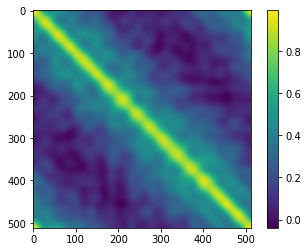

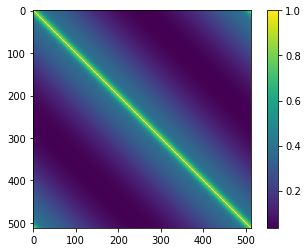

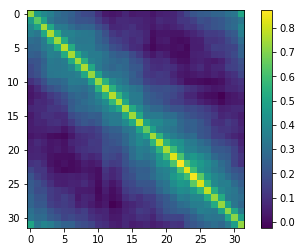

In [114]:
imshow(P_sample_interp_sqrt)
imshow(P_sample_interp_sqrt @ P_sample_interp_sqrt)
imshow(P)
imshow(P_sample_subgrid)

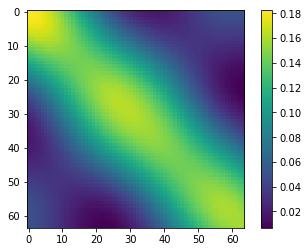

In [118]:
imshow(P_sample_interp_sqrt[:64, :64])

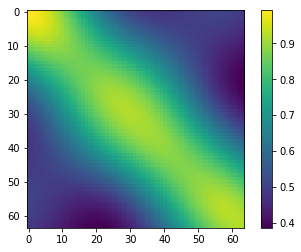

In [119]:
P_sample_interp = P_sample_interp_sqrt @ P_sample_interp_sqrt
imshow(P_sample_interp[:64, :64])

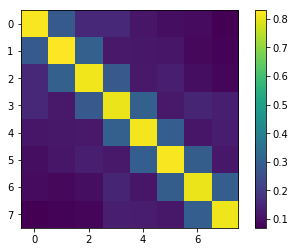

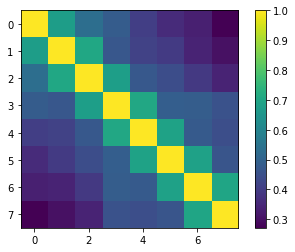

In [120]:
this = U_subgrid @ S_subgrid @ VT_subgrid
that = this @ this
imshow(this[:8, :8])
imshow(that[:8, :8])

In [121]:
ens_size = 30
X = assimilate.generate_ensemble(ens_size=ens_size,
                                       mu=np.zeros(dimension),
                                       eig_val=eig_val,
                                       eig_vec=eig_vec
                                       )
P_sample = np.cov(X)

In [130]:
# P_sample_til = VT_subgrid_interp @ P_inv_sqrt @ P_sample @ P_inv_sqrt @ VT_subgrid_interp.T
D_sqrt = np.diag(np.sqrt(np.diag(P_sample)))
D_inv_sqrt = np.diag(1/np.sqrt(np.diag(P_sample)))
cov_sample = D_inv_sqrt @ P_sample @ D_inv_sqrt
P_sample_til = VT_subgrid_interp @ cov_sample @ VT_subgrid_interp.T

# P_sample_til = P_inv_sqrt @ P_sample @ P_inv_sqrt

In [131]:
proj = (np.eye(dimension) - VT_subgrid_interp[:subgrid_sig_num].T @ VT_subgrid_interp[:subgrid_sig_num])

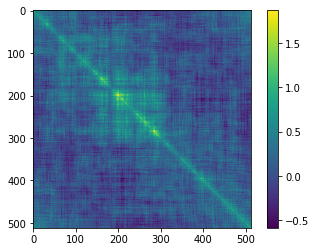

In [132]:
imshow(P_sample)

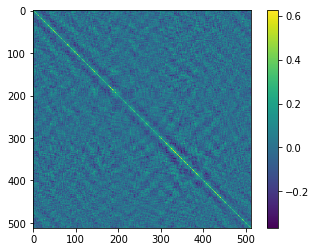

In [133]:
P_orth = proj @ cov_sample @ proj
imshow(P_orth)

<IPython.core.display.Javascript object>


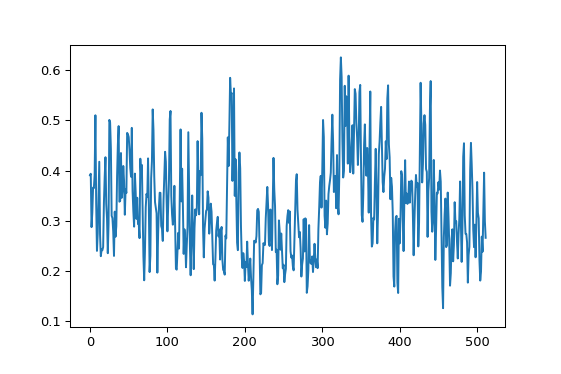

In [158]:
plt.figure()
plt.plot(np.diag(P_orth))

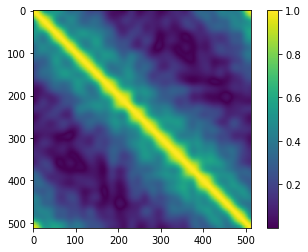

In [134]:
n = 1
P_n = (np.abs(P_sample_interp)**n)
loc = np.diag(np.diag(1/np.sqrt(P_n))) @ P_n @ np.diag(np.diag(1/np.sqrt(P_n)))
imshow(loc)

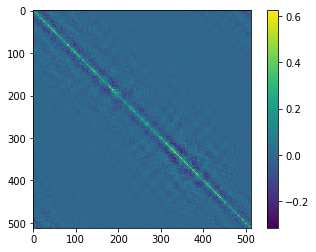

In [135]:
imshow(loc * P_orth)

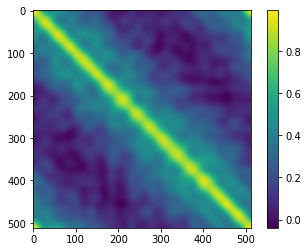

In [136]:
imshow(P_sample_interp)

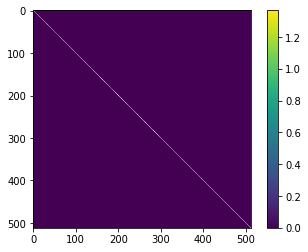

In [140]:
imshow(D_sqrt)

<IPython.core.display.Javascript object>


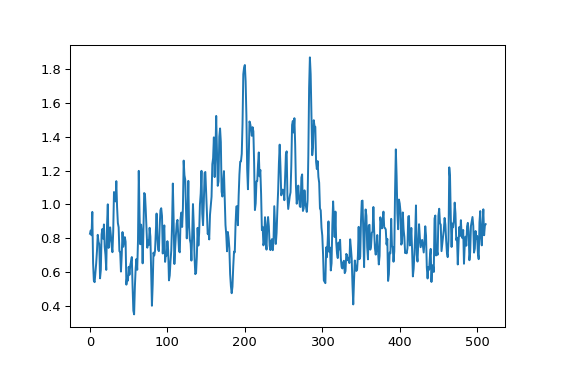

In [154]:
plt.figure()
plt.plot(np.diag(D_sqrt)**2)

In [151]:
%matplotlib notebook

<IPython.core.display.Javascript object>


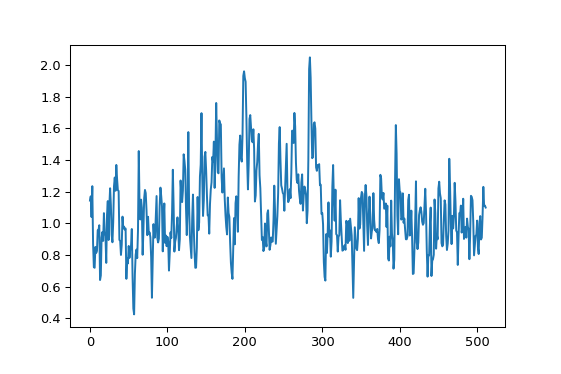

In [155]:
plt.figure()
plt.plot(np.diag(P_sample_loc))

<IPython.core.display.Javascript object>


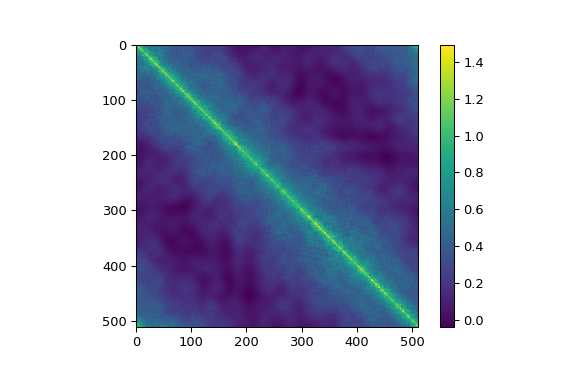

<IPython.core.display.Javascript object>


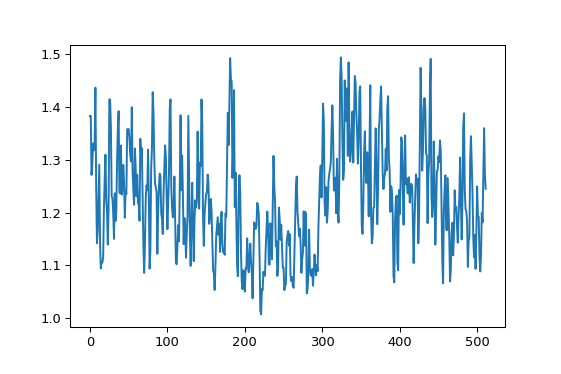

<IPython.core.display.Javascript object>


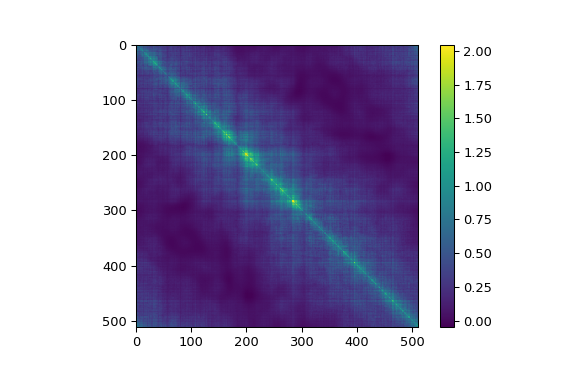

In [156]:
P_sample_loc = P_sample_interp + loc * P_orth
imshow(P_sample_loc)
plt.figure()
plt.plot(np.diag(P_sample_loc))
P_sample_loc = D_sqrt @ P_sample_loc @ D_sqrt
imshow(P_sample_loc)

1


<IPython.core.display.Javascript object>


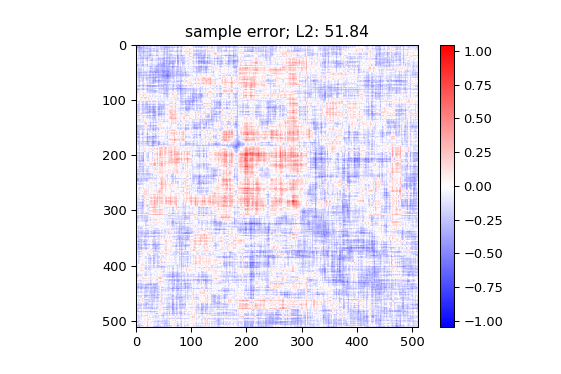

<IPython.core.display.Javascript object>


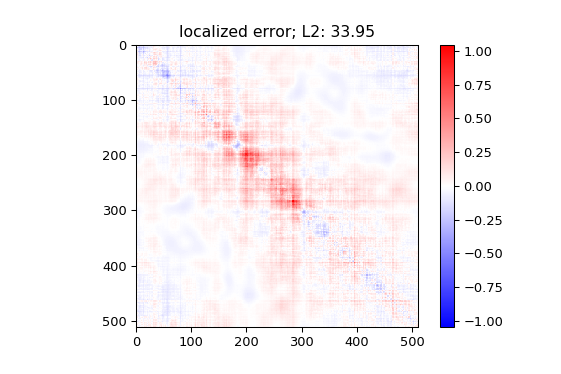

In [153]:
print(n)
error_sample = (P_sample - P)
error_localized = (P_sample_loc) - P
L2_sample = np.round(np.linalg.norm(error_sample, ord=2), decimals=2)
L2_localized = np.round(np.linalg.norm(error_localized, ord=2), decimals=2)
vmax = np.max([np.abs(error_sample).max(), np.abs(error_localized).max()])
imshow(error_sample, vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample error; L2: {L2_sample}')
imshow(error_localized, vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'localized error; L2: {L2_localized}')

# Small coarse ensemble

In [280]:
ens_size = 200
X_large = assimilate.generate_ensemble(ens_size=ens_size,
                                       mu=np.zeros(dimension),
                                       eig_val=eig_val,
                                       eig_vec=eig_vec
                                       )
P_sample_large = np.cov(X_large)

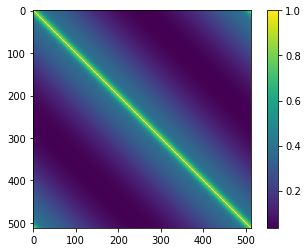

In [281]:
imshow(P)

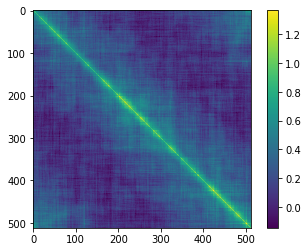

In [282]:
imshow(P_sample_large)

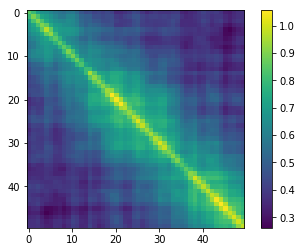

In [283]:
imshow(P_sample_large[:50, :50])

In [284]:
subnum = 16
X_subgrid = X_large.reshape(dimension // subnum, subnum, ens_size)
X_subgrid = X_subgrid.mean(axis=1)
P_sample_subgrid = np.cov(X_subgrid)

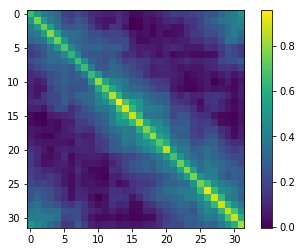

In [285]:
imshow(P_sample_subgrid)

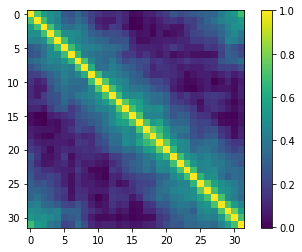

In [288]:
D_inv_sqrt = np.diag(1/np.sqrt(np.diag(P_sample_subgrid)))
rho_sample_subgrid = D_inv_sqrt @ P_sample_subgrid @ D_inv_sqrt
imshow(rho_sample_subgrid)

In [287]:
H_subgrid = np.eye(P_sample_subgrid.shape[0])
R_subgrid = R_sig * np.eye(P_sample_subgrid.shape[0])
trans_mats = assimilate.transformation_matrices(
    H_subgrid, P=P_sample_subgrid,
    R=R_subgrid, return_Ts=True)

for key, val in trans_mats.items():
    key = key + '_subgrid'
    print(key)
    exec(key + '=val')


H_subgrid = np.eye(P_sample_subgrid.shape[0])
R_subgrid = R_sig * np.eye(P_sample_subgrid.shape[0])
trans_mats = assimilate.transformation_matrices(
    H_subgrid, P=P_sample_subgrid,
    R=R_subgrid, return_Ts=True)

for key, val in trans_mats.items():
    key = key + '_subgrid'
    print(key)
    exec(key + '=val')

P_sqrt_subgrid
P_inv_sqrt_subgrid
R_sqrt_subgrid
R_inv_sqrt_subgrid
U_subgrid
S_subgrid
VT_subgrid
H_subgrid
Tx_subgrid
Tx_inv_subgrid
Ty_subgrid
Ty_inv_subgrid


In [241]:
x_interp = np.arange(dimension)
# x_data = np.concatenate(
#     [x_interp[::subnum], [x_interp[-1] + 1]]) + 3.5
x_data = x_interp.reshape(int(dimension/subnum), subnum).mean(axis=1)
x_data = np.concatenate([[x_data[0] - subnum],
                         x_data,
                         [x_data[-1] + subnum]])
# x_data = np.concatenate(
#     [x_interp[::subnum], [x_interp[-1] + 1]]) + 3.5

In [242]:
VT_data = np.concatenate([VT_subgrid[:, -1][:, None],
                          VT_subgrid,
                          VT_subgrid[:, 0][:, None]],
                         axis=1)

In [243]:
interp_kind = 'cubic'
VT_fun = interpolate.interp1d(x_data, VT_data, kind=interp_kind, axis=1)

In [244]:
VT_subgrid_interp = VT_fun(x_interp)/np.sqrt(subnum)

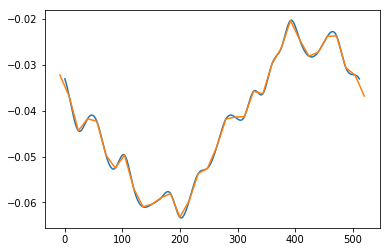

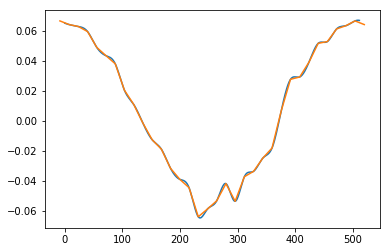

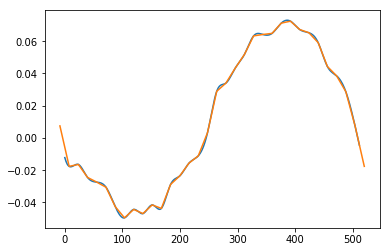

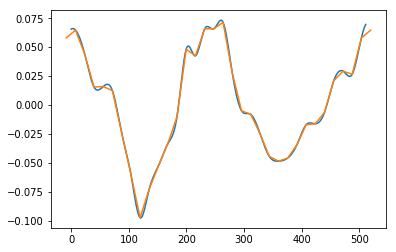

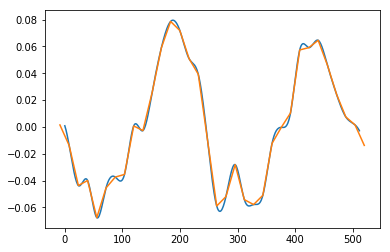

In [245]:
for ii in range(5):
    plt.figure()
    plt.plot(VT_subgrid_interp[ii])
    plt.plot(x_data, VT_data[ii]/np.sqrt(subnum))

In [246]:
U_data = np.concatenate([U_subgrid[-1, :][None, :],
                         U_subgrid,
                         U_subgrid[0, :][None, :]],
                        axis=0)

In [247]:
U_fun = interpolate.interp1d(x_data, U_data, kind=interp_kind, axis=0)

In [248]:
subnum

16

In [249]:
U_subgrid_interp = U_fun(x_interp)/np.sqrt(subnum)

In [250]:
%matplotlib inline

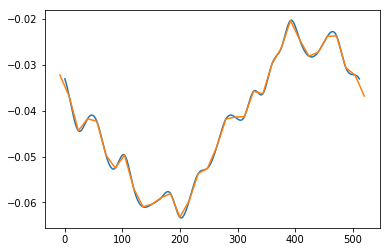

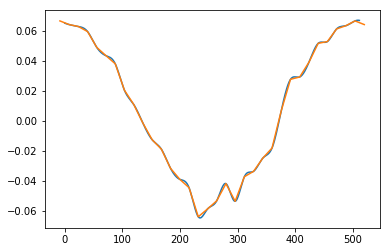

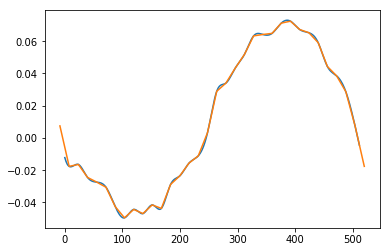

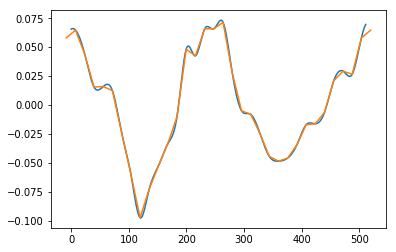

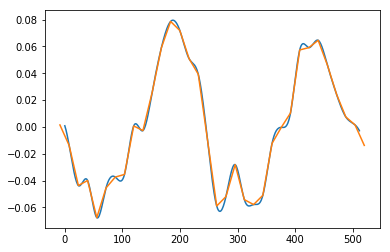

In [251]:
for ii in range(5):
    plt.figure()
    plt.plot(U_subgrid_interp[:, ii])
    plt.plot(x_data, U_data[:, ii]/np.sqrt(subnum))

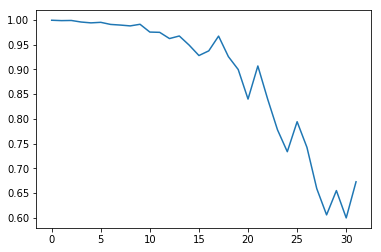

In [252]:
plt.plot(np.diag(U_subgrid_interp.T @ U_subgrid_interp))

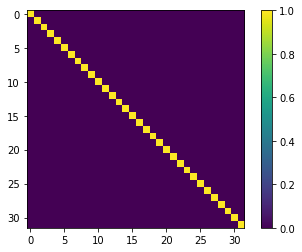

In [253]:
imshow(U_subgrid.T @ U_subgrid)

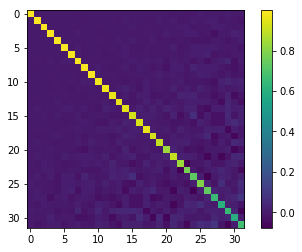

In [254]:
imshow(U_subgrid_interp.T @ U_subgrid_interp)

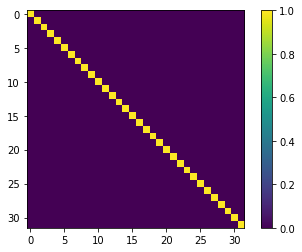

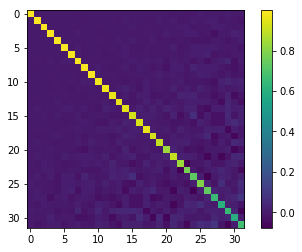

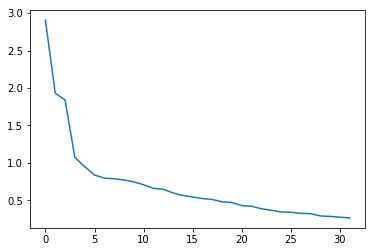

In [255]:
imshow(VT_subgrid @ VT_subgrid.T)
imshow(VT_subgrid_interp @ VT_subgrid_interp.T)
plt.figure()
plt.plot(np.diag(S_subgrid))

In [256]:
S_subgrid_interp = S_subgrid * np.sqrt(subnum)

In [257]:
subgrid_sig_num = 5

In [258]:
P_sample_interp_sqrt = (
    U_subgrid_interp[:, :subgrid_sig_num]
    @ S_subgrid_interp[:subgrid_sig_num, :subgrid_sig_num]
    @ VT_subgrid_interp[:subgrid_sig_num, :])
P_sample_interp = P_sample_interp_sqrt @ P_sample_interp_sqrt

In [259]:
%matplotlib notebook

In [260]:
%matplotlib inline

In [261]:
P_sample_interp.trace()/dimension

0.5488352433037063

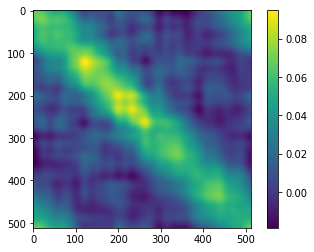

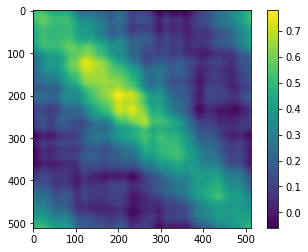

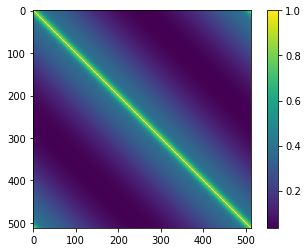

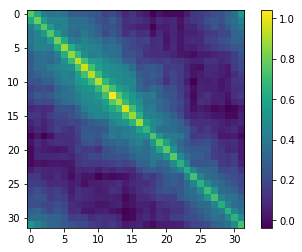

In [262]:
imshow(P_sample_interp_sqrt)
imshow(P_sample_interp_sqrt @ P_sample_interp_sqrt)
imshow(P)
imshow(P_sample_subgrid)

In [263]:
ens_size = 30
X = assimilate.generate_ensemble(ens_size=ens_size,
                                       mu=np.zeros(dimension),
                                       eig_val=eig_val,
                                       eig_vec=eig_vec
                                       )
P_sample = np.cov(X)

In [264]:
# P_sample_til = VT_subgrid_interp @ P_inv_sqrt @ P_sample @ P_inv_sqrt @ VT_subgrid_interp.T
P_sample_til = VT_subgrid_interp @ P_sample @ VT_subgrid_interp.T

# P_sample_til = P_inv_sqrt @ P_sample @ P_inv_sqrt

In [265]:
proj = (np.eye(dimension) - VT_subgrid_interp[:subgrid_sig_num].T @ VT_subgrid_interp[:subgrid_sig_num])

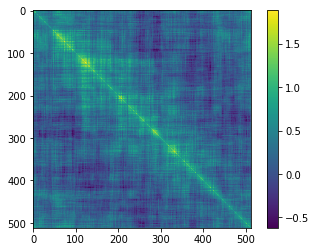

In [266]:
imshow(P_sample)

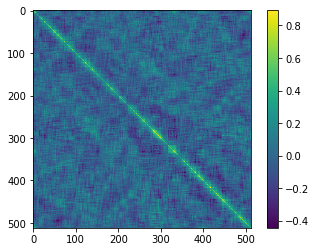

In [267]:
P_orth = proj @ P_sample @ proj
imshow(P_orth)

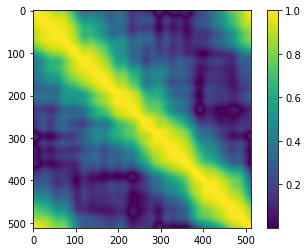

In [268]:
n = 1
P_n = (np.abs(P_sample_interp)**n)
loc = np.diag(np.diag(1/np.sqrt(P_n))) @ P_n @ np.diag(np.diag(1/np.sqrt(P_n)))
imshow(loc)

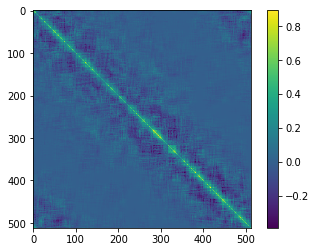

In [269]:
imshow(loc * P_orth)

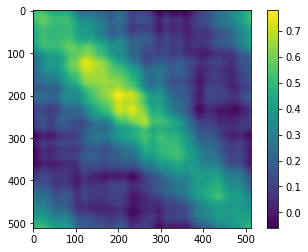

In [270]:
imshow(P_sample_interp)

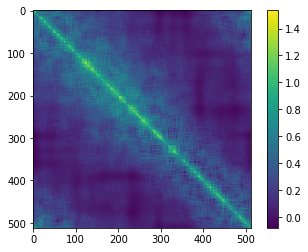

In [271]:
P_sample_loc = P_sample_interp + loc * P_orth
imshow(P_sample_loc)

1


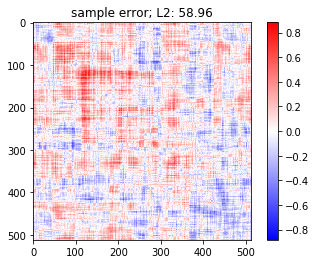

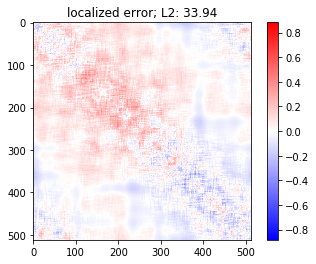

In [272]:
print(n)
error_sample = (P_sample - P)
error_localized = (P_sample_loc) - P
L2_sample = np.round(np.linalg.norm(error_sample, ord=2), decimals=2)
L2_localized = np.round(np.linalg.norm(error_localized, ord=2), decimals=2)
vmax = np.max([np.abs(error_sample).max(), np.abs(error_localized).max()])
imshow(error_sample, vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample error; L2: {L2_sample}')
imshow(error_localized, vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'localized error; L2: {L2_localized}')

/home/travis/miniconda3/envs/loc/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Text(0, 0.5, 'error')

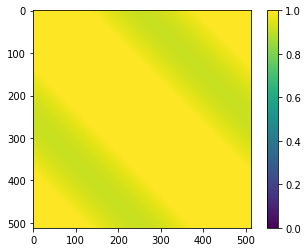

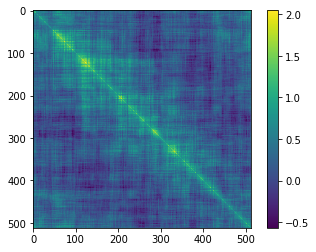

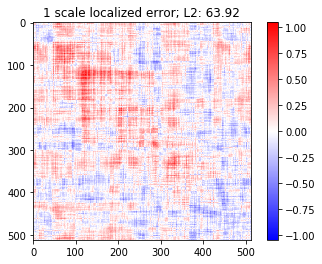

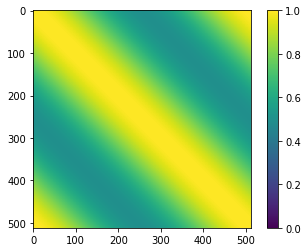

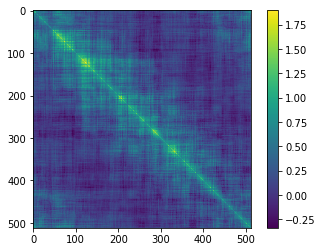

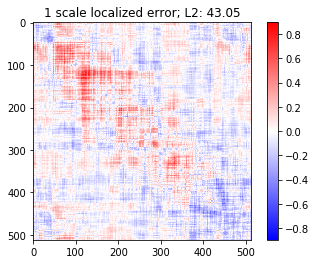

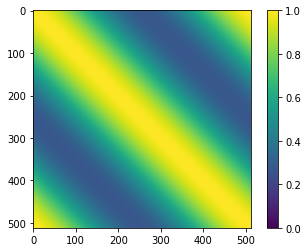

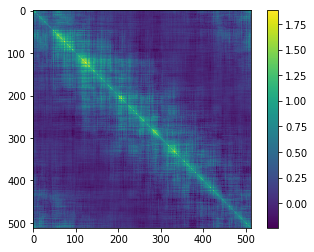

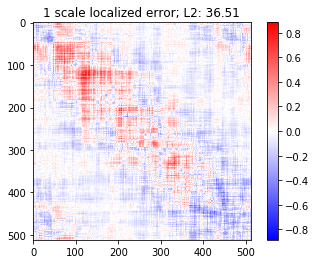

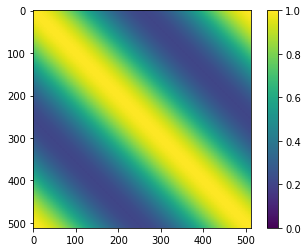

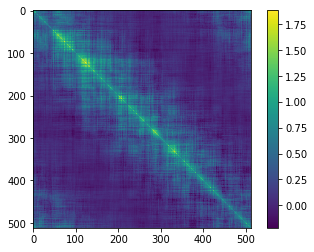

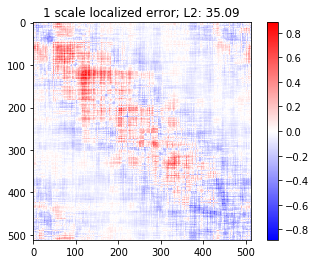

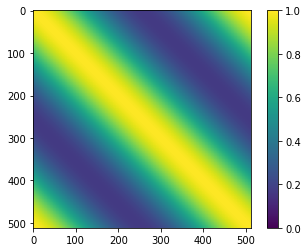

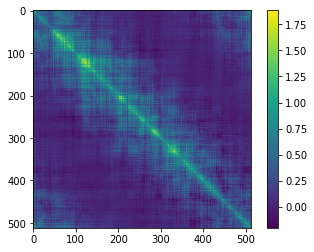

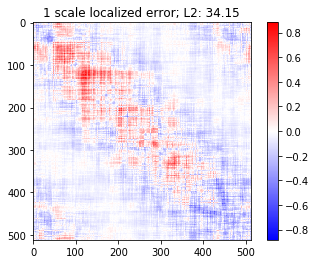

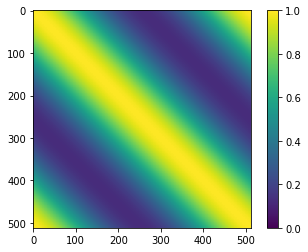

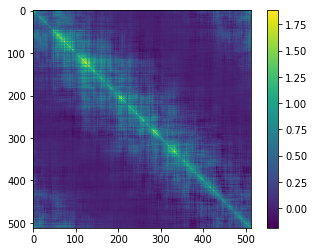

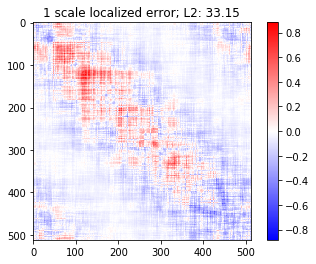

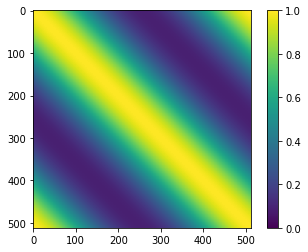

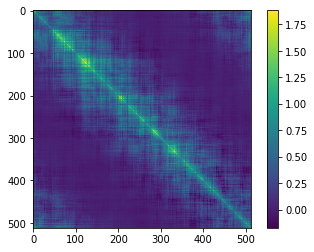

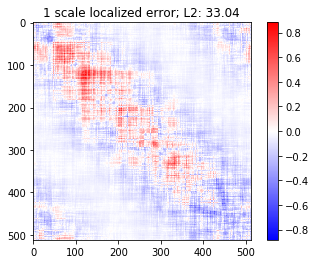

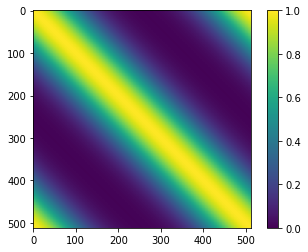

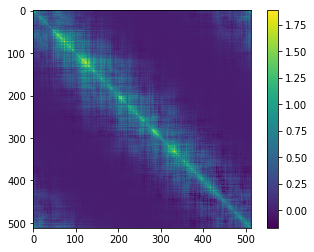

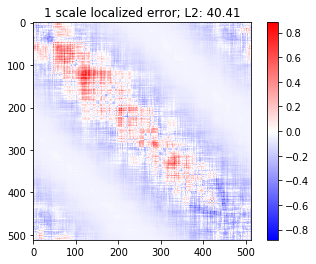

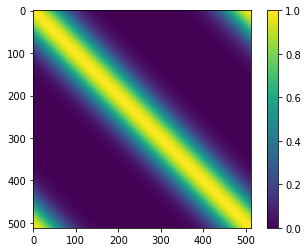

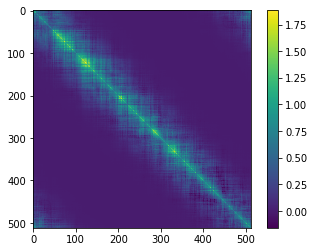

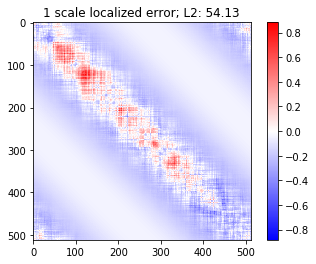

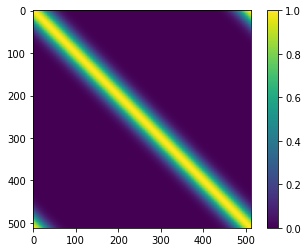

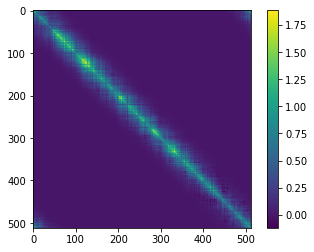

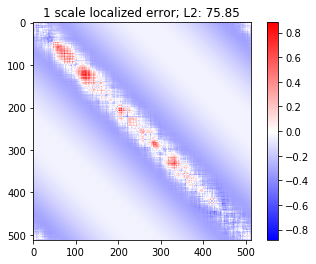

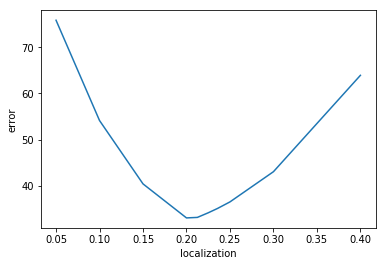

In [273]:
loc_list = [.4, .3, .25,.2357, .225,.2125, .2, .15, .1, .05]
error_list = np.ones_like(loc_list) * np.nan
for count, rho_loc in enumerate(loc_list):
    [this_loc] = covariance.generate_circulant(
        dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
        return_Corr=True, return_eig=False)
    imshow(this_loc, vmin=0, vmax=1)
    
    error_1_localized = this_loc * P_sample - P
    L2_1_localized = np.round(np.linalg.norm(error_1_localized, ord=2), decimals=2)
    error_list[count] = L2_1_localized
    vmax = np.max([np.abs(error_sample).max(),
                   np.abs(error_localized).max(),
                   np.abs(error_1_localized).max()])
    imshow(this_loc * P_sample)
    imshow(error_1_localized, vmax=vmax, vmin=-vmax, cmap='bwr',
           title=f'1 scale localized error; L2: {L2_1_localized}')

plt.figure()
plt.plot(loc_list, error_list)
plt.xlabel('localization')
plt.ylabel('error')

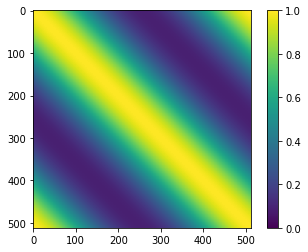

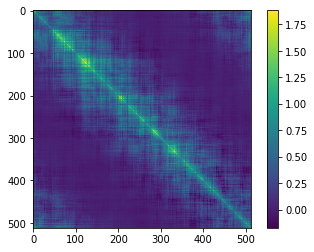

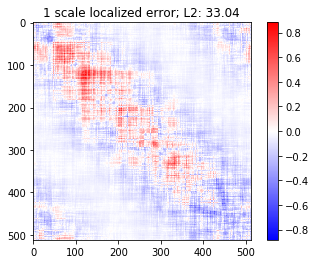

In [274]:
rho_loc = loc_list[np.argmin(error_list)]
[this_loc] = covariance.generate_circulant(
    dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_eig=False)
imshow(this_loc, vmin=0, vmax=1)

error_1_localized = this_loc * P_sample - P
L2_1_localized = np.round(np.linalg.norm(error_1_localized, ord=2), decimals=2)
error_list[count] = L2_1_localized
vmax = np.max([np.abs(error_sample).max(),
               np.abs(error_localized).max(),
               np.abs(error_1_localized).max()])
imshow(this_loc * P_sample)
imshow(error_1_localized, vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'1 scale localized error; L2: {L2_1_localized}')